<a href="https://colab.research.google.com/github/avagonick/Sentient-Analysis/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment-140 Classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import csv
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification


## Loading the data

In [ ]:
class SentimentDataset(Dataset):

    def __init__(self, csv_path, training_set=True):
        tweets = []
        labels = []
        with open(csv_path, 'r') as file:
            csv_reader = csv.reader(file)
            for row in csv_reader:
                tweets.append(row[0])
                labels.append(int(row[1]))

        total_tweets = len(tweets)
        train_indices = np.random.choice(total_tweets, int(0.8 * total_tweets), replace=False)
        test_indices = np.setdiff1d(np.arange(total_tweets), train_indices)

        if training_set:
            self.tweets = [tweets[i] for i in train_indices]
            self.labels = [labels[i] for i in train_indices]
        else:
            self.tweets = [tweets[i] for i in test_indices]
            self.labels = [labels[i] for i in test_indices]

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        return self.tweets[idx], self.labels[idx]

In [ ]:
use_subset_of_data = True
subset_percentage = 0.01 # set the percentage of original dataset when running on CoLab so it doesn't take forever

In [10]:
data_loc = '/content/drive/MyDrive/Older stuff/ACM AI Projects/dataset.csv'

train_data = SentimentDataset(data_loc, training_set=True)
test_data = SentimentDataset(data_loc, training_set=False)

if use_subset_of_data:
    train_set_len = int(subset_percentage * len(train_data))
    test_set_len = int(subset_percentage * len(test_data))

    train_subset_indices = np.random.choice(len(train_data), size=train_set_len, replace=False)
    train_sampler = SubsetRandomSampler(train_subset_indices)

    test_subset_indices = np.random.choice(len(test_data), size=test_set_len, replace=False)
    test_sampler = SubsetRandomSampler(test_subset_indices)

    train_loader = DataLoader(train_data, batch_size=32, sampler=train_sampler)
    test_loader = DataLoader(test_data, batch_size=32, sampler=test_sampler)

else:
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

#Write Out Example Data

In [ ]:
tweets, labels = next(iter(train_loader))
print("Sample tweet: ", tweets[0])
print("Ground truth label: ", labels[0].numpy())

Sample tweet:  @blondishnet even I can't FTP to Fan History.  No FTP installed. 
Ground truth label:  0


## Start By Fine-tuning BERT from Hugging Face

In [11]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
pretrained_model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#Preprocess data to get tokens and attention masks

In [ ]:
def preprocess(tweets):

    encoded_batch = tokenizer.batch_encode_plus(
        tweets,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoded_batch['input_ids']
    attention_masks = encoded_batch['attention_mask']

    return input_ids, attention_masks

#Write Train and Eval Loop

In [ ]:
def train(model, train_loader, val_loader, optimizer, criterion, device,
          num_epochs, finetuning=False):

    # Place model on device, this is for when using the GPU
    model = model.to(device)

    loss_history = []
    acc_history = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        # Use tqdm to display a progress bar during training
        with tqdm(total=len(train_loader),
                  desc=f'Epoch {epoch + 1}/{num_epochs}',
                  position=0,
                  leave=True) as pbar:

            for inputs, labels in train_loader:

                input_ids, attention_masks = preprocess(inputs)
                # Move inputs and labels to device
                input_ids = input_ids.to(device)
                attention_masks = attention_masks.to(device)
                labels = labels.to(device)

                # Zero out gradients
                optimizer.zero_grad()

                # Compute the logits and loss
                outputs = model(input_ids=input_ids, attention_mask=attention_masks)
                if finetuning:
                    outputs = outputs.logits
                loss = criterion(outputs, labels)

                # Backpropagate the loss
                loss.backward()

                # Update the weights
                optimizer.step()

                # Update the progress bar
                pbar.update(1)
                pbar.set_postfix(loss=loss.item())

                loss_history.append(loss.item())


        avg_loss, accuracy = evaluate(model, val_loader, criterion, device, finetuning)
        print(
            f'Test set: Average loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}'
        )
        acc_history.append(accuracy)

    return loss_history, acc_history


def evaluate(model, test_loader, criterion, device, finetuning=False):

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        total_loss = 0.0
        num_correct = 0
        num_samples = 0

        for inputs, labels in test_loader:

            input_ids, attention_masks = preprocess(inputs)
            # Move inputs and labels to device
            input_ids = input_ids.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            # Compute the logits and loss
            outputs = model(input_ids=input_ids, attention_mask=attention_masks)
            if finetuning:
                outputs = outputs.logits
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Compute the accuracy
            _, predictions = torch.max(outputs, dim=1)
            num_correct += (predictions == labels).sum().item()
            num_samples += len(labels)

    # Compute the average loss and accuracy
    avg_loss = total_loss / len(test_loader)
    accuracy = num_correct / num_samples

    return avg_loss, accuracy

Get device, because when on gpu can use cude

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#Fine Tune BERT
Here just doing a small amount to make sure the code works

In [ ]:
optimizer = torch.optim.AdamW(pretrained_model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

loss_history, acc_history = train(pretrained_model, train_loader, test_loader, optimizer, criterion, device, num_epochs=1, finetuning=True)

# Let's save our trained weights
torch.save(pretrained_model.state_dict(), '/content/drive/MyDrive/bert_fine_tuned.pt')



Epoch 1/1: 100%|██████████| 40/40 [00:24<00:00,  1.63it/s, loss=0.602]


Test set: Average loss = 0.5313, Accuracy = 0.7250


In [ ]:
#in model.eval can pass in own things and test
test_regular = [("hello", 1), ("bad", 0)]
test_loaded = DataLoader(test_regular)
print(evaluate(pretrained_model,test_loaded, criterion, device, finetuning = True ))

(0.241719551384449, 1.0)


Next, let's plot our training loss and test accuracy history that documents the fine-tuning process.

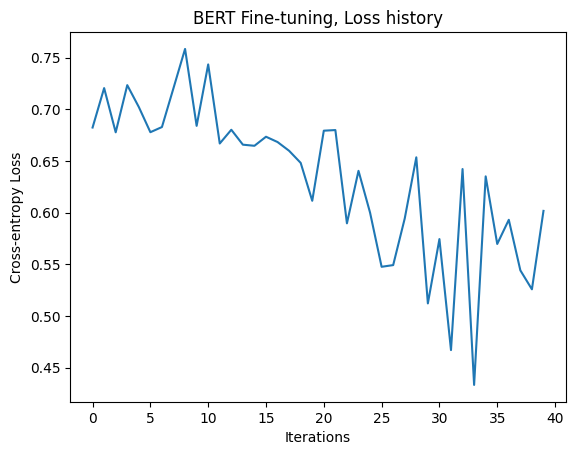

In [ ]:
plt.plot(loss_history)
plt.xlabel('Iterations')
plt.ylabel('Cross-entropy Loss')
plt.title('BERT Fine-tuning, Loss history')
plt.show()

## Creating own Transformer architecture from scratch

Some Hyperparameters To Use

In [ ]:
MAX_SEQ_LEN = 128 # Maximum length of tokenized input sequence (we already covered this above!)
VOCAB_SIZE = 30522 # number of different token -> ID mappings, specific to the BERT Tokenizer (do not change)
N_LAYERS = 12 # number of transformer layers stacked on top of each other
N_HEADS = 12 # number of heads of the transformer, input sequence will be split and equally distributed to each head
EMB_SIZE = 768 # refers to the dimensionality of the vector representations used to encode input tokens
INTERMEDIATE_SIZE = EMB_SIZE * 4 # dimensionality of output of the Intermediate layer
DROPOUT = 0.1 # probability of dropping a neuron during training
N_CLASSES = 2 # we are classifying the sentiment of each tweet simply as POSITIVE or NEGATIVE
LAYER_NORM_EPS = 1e-12 # value used in Layer Norm for numerical stability

#Make Embedding Layer

In [ ]:
class EmbeddingLayer(nn.Module):

    def __init__(self, vocab_size, emb_size, max_seq_length, layer_norm_eps=1e-12, dropout=0.1):
        super().__init__()

        # TODO: Initialize word embeddings
        self.word_embeddings = nn.Embedding(vocab_size, emb_size)
        #take in position then output embedding
        #padding our input to max sequence length
        self.position_embeddings = nn.Embedding(max_seq_length, emb_size)
        self.ln = nn.LayerNorm(emb_size, eps = layer_norm_eps)
        self.dropout = nn.Dropout(dropout)

        # sets self.position_ids to a tensor containing values from 0 to max_seq_length, reshaped to (1, max_seq_length)
        # register_buffer makes it so that this does NOT get updated during training
        self.register_buffer("position_ids", torch.arange(max_seq_length).expand((1, -1)))

#now need to make the forward pass
    def forward(self, input_ids):
      wordEmbed = self.word_embeddings(input_ids)
      posEmbed = self.position_embeddings(self.position_ids)
      normalize = self.ln(wordEmbed + posEmbed)
      emb = self.dropout(normalize)

      return emb


#Make Multi Head Attention Layer

In [ ]:
class MultiHeadAttention(nn.Module):

    def __init__(self, emb_size, n_heads, dropout=0.1, layer_norm_eps=1e-12):
        '''
        Args:
            emb_size (int): The size of the input embeddings
            n_heads (int): The number of attention heads
            dropout (float): The dropout probability
            layer_norm_eps (float): The epsilon value for layer normalization

        '''
        super().__init__()
        assert emb_size % n_heads == 0, "emb_size must be divisible by n_heads"


        # you want to use nn.Linear, nn.Dropout, nn.LayerNorm
        # query, key, value, final_linear should map from emb_size to emb_size
        self.head_size = emb_size // n_heads
        self.n_heads = n_heads
        self.query = nn.Linear(emb_size, emb_size)
        self.key = nn.Linear(emb_size, emb_size)
        self.value = nn.Linear(emb_size, emb_size)
        self.dropout = nn.Dropout(p = dropout)
        self.final_linear = nn.Linear(emb_size, emb_size)
        self.ln = nn.LayerNorm(emb_size, eps = emb_size)


    def forward(self, emb, att_mask):
        '''
        Args:
            emb (torch.Tensor): The input embeddings with shape (B, T, C)
            att_mask (torch.Tensor): The attention mask with shape (B, T)

        Returns:
            torch.Tensor: The output embeddings with shape (B, T, C)

        1. You want to obtain the query (Q), key (K), and value (V) tensors from the input embeddings
        2. Compute weights:
            a. find dot product of Q and K
            b. divide by the square root of the head size
            c. apply the attention mask
            d. apply softmax
        3. Compute attention: multiply weights by V
        4. Feed the attention through the final linear layer
        5. Apply dropout, residual connection, and layer normalization

        '''
        B, T, C = emb.shape  # batch size, sequence length, embedding size

        #get the query, key, and value tensors

        query = self.query(emb)
        key = self.key(emb)
        value = self.value(emb)


        # rearrange the tensors from B x T x C to B x n_heads x T x head_size


        q = torch.reshape(query, (B, self.n_heads, T, self.head_size))
        k = torch.reshape(key, (B, self.n_heads, T, self.head_size))
        v = torch.reshape(value, (B, self.n_heads, T, self.head_size))

        #compute the weights before attention mask
        #because the last dimenion of q must match the second to last dimenion of k
        #since they are currently the same size switching them should work
        weights = torch.matmul(q, torch.transpose(k, -2, -1)*self.head_size**-0.5)
        # set the pad tokens to -inf so that they equal zero after softmax
        if att_mask != None:
            att_mask = (att_mask > 0).unsqueeze(1).repeat(1, att_mask.size(1), 1).unsqueeze(1)
            weights = weights.masked_fill(att_mask == 0, float('-inf'))

        # apply softmax and dropout
        weights = F.softmax(weights, dim = -1)
        weights = self.dropout(weights)

        # compute attention
        attention = torch.matmul(weights, v)

        # rearrange the attention tensor from B x n_heads x T x head_size to B x T x C
        attention = torch.reshape(attention, (B, T, C))

        # apply final linear layer, dropout, residual connection, and layer normalization
        out = self.final_linear(attention)
        out = self.dropout(out)
        #need to add it back to the originals
        out = out + emb
        out = self.ln(out)

        return out


# Feed Forward Layer

In [ ]:
class PositionWiseFeedForward(nn.Module):

    def __init__(self, emb_size, intermediate_size, dropout=0.1, layer_norm_eps=1e-12):
        '''
        Args:
            emb_size (int): The size of the input embeddings
            intermediate_size (int): The size of the intermediate layer
            dropout (float): The dropout probability
            layer_norm_eps (float): The epsilon value for layer normalization

        We want to create two fully connected layers mapping from emb_size to intermediate_size and back
        '''

        #initialize the two fully connected layers, gelu, dropout, and layer norm
        super().__init__()
        self.fc1 = nn.Linear(emb_size, intermediate_size)
        self.fc2 = nn.Linear(intermediate_size, emb_size)

        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(p = dropout)
        self.ln = nn.LayerNorm(emb_size, eps = layer_norm_eps)

    def forward(self, att_out):
        '''
        Args:
            att_out (torch.Tensor): The output embeddings from the multi-head attention layer with shape (B, T, C)

        Returns:
            torch.Tensor: The output embeddings with shape (B, T, C)

        TODO:
        1. Apply the first fully connected layer and non-linearity
        2. Apply the second fully connected layer and dropout
        3. Apply a residual connection and layer normalization
        '''
        #so applying these two linear layers to each of the position embeddings
        #pytorch will do this if you give it the entire tensor
        x = self.fc1(att_out)
        x = self.gelu(x)
        x = self.fc2(x)
        x = x + att_out
        out = self.ln(x)


        return out

# Transformer Block: Putting It All Together

In [ ]:
class TransformerBlock(nn.Module):

    def __init__(self, emb_size, n_heads, intermediate_size, dropout=0.1, layer_norm_eps=1e-12):
        '''
        Args:
            emb_size (int): The size of the input embeddings
            n_heads (int): The number of attention heads
            intermediate_size (int): The size of the intermediate layer
            dropout (float): The dropout probability
            layer_norm_eps (float): The epsilon value for layer normalization

        We want to create a transformer block that consists of a multi-head attention layer and a position-wise feed forward layer.
        Note: We took care of layer normalization and residual connections in the previous MultiHeadAttention and PositionWiseFeedForward classes
        '''

        #initialization
        super().__init__()
        self.attn = MultiHeadAttention(emb_size, n_heads, dropout = dropout, layer_norm_eps = layer_norm_eps)
        self.ff = PositionWiseFeedForward(emb_size, intermediate_size, dropout = dropout, layer_norm_eps = layer_norm_eps)

    def forward(self, emb, att_mask):
        '''
        Args:
            emb (torch.Tensor): The input embeddings with shape (B, T, C)
            att_mask (torch.Tensor): The attention mask with shape (B, T)

        Returns:
            torch.Tensor: The output embeddings with shape (B, T, C)

        Take emb and att_mask and pass them through the multi-head attention layer and position-wise feed forward layer
        '''
        x = self.attn.forward(emb, att_mask)
        out = self.ff.forward(x)

        return out

# Encoder Block


In [ ]:
class EncoderBlock(nn.Module):

    def __init__(self, emb_size, n_layers, n_heads, intermediate_size, dropout=0.1, layer_norm_eps=1e-12):
        '''
        Args:
            emb_size (int): The size of the input embeddings
            n_layers (int): The number of transformer blocks
            n_heads (int): The number of attention heads
            intermediate_size (int): The size of the intermediate layer
            dropout (float): The dropout probability
            layer_norm_eps (float): The epsilon value for layer normalization

        We want to create n_layers of transformer blocks
        '''
        super().__init__()

        #initialize transformer layers
        self.transformer_layers = nn.ModuleList([TransformerBlock(emb_size, n_heads, intermediate_size, dropout = dropout, layer_norm_eps = layer_norm_eps) for i in range(n_layers)])

    def forward(self, emb, att_mask):
        '''
        Args:
            emb (torch.Tensor): The input embeddings with shape (B, T, C)
            att_mask (torch.Tensor): The attention mask with shape (B, T)

        Returns:
            torch.Tensor: The output embeddings with shape (B, T, C)

        Pass the input embeddings through each transformer block
        '''
        for i in range(len(self.transformer_layers)):
          emb = self.transformer_layers[i].forward(emb, att_mask)

        return emb

#Pooler activation function

In [ ]:
class Pooler(nn.Module):
    def __init__(self, emb_size):
        '''
        Args:
            emb_size (int): The size of the input embeddings
        '''
        super().__init__()

        #Define the linear layer and activation function
        self.dense = nn.Linear(emb_size, emb_size)
        self.activation = nn.Tanh()

    def forward(self, encoder_out):
        '''
        Args:
            encoder_out (torch.Tensor): The output embeddings from the encoder with shape (B, T, C)

        Returns:
            torch.Tensor: The pooled embeddings with shape (B, C)
        '''

        # TODO: 1. extract the first token's embeddings
        firsttoken = encoder_out[:,0]
        # TODO: 2. apply the linear layer and activation function
        x = self.dense(firsttoken)
        out = self.activation(x)

        return out

#Final Model

In [ ]:
class SimplifiedBertClassifier(nn.Module):
    def __init__(self, vocab_size, emb_size, max_seq_length, n_layers, n_heads, intermediate_size,layer_norm_eps, dropout=0.1, n_classes=2):
        '''
        Args:
            vocab_size (int): The size of the vocabulary
            emb_size (int): The size of the input embeddings
            n_layers (int): The number of transformer blocks
            n_heads (int): The number of attention heads
            intermediate_size (int): The size of the intermediate layer
            dropout (float): The dropout probability
            n_classes (int): The number of classes
        '''
        super().__init__()

        # TODO: Initialization
        self.embedding = EmbeddingLayer(vocab_size, emb_size, max_seq_length, layer_norm_eps, dropout)
        self.encoder = EncoderBlock(emb_size, n_layers, n_heads, intermediate_size, dropout = dropout, layer_norm_eps = layer_norm_eps)
        self.pooler = Pooler(emb_size)
        self.dropout = nn.Dropout(p = dropout)
        self.classifier = nn.Linear(emb_size, n_classes)

    def forward(self, input_ids, attention_mask=None):
        '''
        Args:
            input_ids (torch.Tensor): The input token IDs with shape (B, T)
            attention_mask (torch.Tensor): The attention mask with shape (B, T)

        Returns:
            torch.Tensor: The logits with shape (B, n_classes)

        1. Pass the input token IDs through the embedding layer, encoder, pooler
        2. Apply dropout
        3. Pass the output through the classifier
        '''

        # TODO:
        x = self.embedding.forward(input_ids)
        x = self.encoder.forward(x, attention_mask)
        x = self.pooler.forward(x)
        x = self.dropout(x)
        logits = self.classifier(x)

        return logits

#Train Model, using quantization when on CoLab to speed it up

In [ ]:
pip install quanto

In [ ]:
from quanto import quantize
our_model = SimplifiedBertClassifier(vocab_size=VOCAB_SIZE, emb_size=EMB_SIZE, n_layers=N_LAYERS,
                                     n_heads=N_HEADS, intermediate_size=INTERMEDIATE_SIZE, dropout=DROPOUT, n_classes=N_CLASSES, max_seq_length = MAX_SEQ_LEN, layer_norm_eps = LAYER_NORM_EPS)
quantize(our_model, weights=quanto.qint8, activations=quanto.qint8)
optimizer = torch.optim.AdamW(our_model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

loss_history, acc_history = train(our_model, train_loader, test_loader, optimizer, criterion, device, num_epochs=3, finetuning=False)
torch.save(our_model.state_dict(), 'bert_from_scratch.pt')


Epoch 1/3: 100%|██████████| 400/400 [05:27<00:00,  1.22it/s, loss=0.693]


Test set: Average loss = 0.6931, Accuracy = 0.5050


Epoch 2/3: 100%|██████████| 400/400 [03:55<00:00,  1.70it/s, loss=0.693]


Test set: Average loss = 0.6931, Accuracy = 0.5050


Epoch 3/3: 100%|██████████| 400/400 [03:54<00:00,  1.71it/s, loss=0.693]


Test set: Average loss = 0.6931, Accuracy = 0.5050


In [ ]:
plt.plot(loss_history)
plt.xlabel('Iterations')
plt.ylabel('Cross-entropy Loss')
plt.title('BERT From Scratch, Loss history')
plt.show()

In [ ]:
plt.plot(acc_history)
plt.xlabel('Epochs')
plt.ylabel('Test accuracy')
plt.title('BERT From Scratch, Accuracy history')
plt.show()
print(acc_history)